# Demo notbook TSP

Demo notebook comparing two different approaches to solve the traveling
salesman problem (TSP). Namely a brute force algorim and the quantum Grover
algorithm. 

### Import of our self written modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.grover import Grover
from src.brute_force_solver import BruteForceSolver
from src import helpers

Firstly, let us motivate why a brute force approach of solving the TSP problem
is not feasible for large sets of cities. Below you can see the total amounts of
possible permutations of the traveling sequence. You see that the amount of
solutions scales indeed with (N-1)!

In [2]:
brute = BruteForceSolver()
for nr_cities in range(3,12):
    brute.set_cities_coordinates(nr_cities, 20)
    print(
        f"{nr_cities} cities have {len(brute.get_all_possible_sequences())}"
        " possible travel paths"
        )

3 cities have 2 possible travel paths
4 cities have 6 possible travel paths
5 cities have 24 possible travel paths
6 cities have 120 possible travel paths
7 cities have 720 possible travel paths
8 cities have 5040 possible travel paths
9 cities have 40320 possible travel paths
10 cities have 362880 possible travel paths
11 cities have 3628800 possible travel paths


Now we want to compare this brute force alogrithm with our Grover solver.
Firstly, solver objects are instanciated. To quantify the grover algorithm we solve the
TSP problem with brute force as well by calculating all possible solutions and
searchig for the shortest route result. A random set of cities is generated with
`set_cities_coordinates` on a 20x20 grid.

In [3]:
grover = Grover()
brute = BruteForceSolver()
cities = grover.set_cities_coordinates(4, 20)
brute.cities = cities
brute.grid_size = 20

Let us inspect the randomly generated cities:

In [4]:
grover.cities

{'0': array([12,  7]),
 '1': array([ 4, 19]),
 '2': array([19,  1]),
 '3': array([10, 13])}

And inspect their inter city distances:

In [5]:
grover.calculate_distances(cities)

{'10': 14, '20': 9, '21': 23, '30': 6, '31': 8, '32': 15}

To visualize the problem to be solved, one can plot the cities on the given map
with `plot_cities_on_grid`

(<Figure size 500x500 with 1 Axes>, <Axes: >)

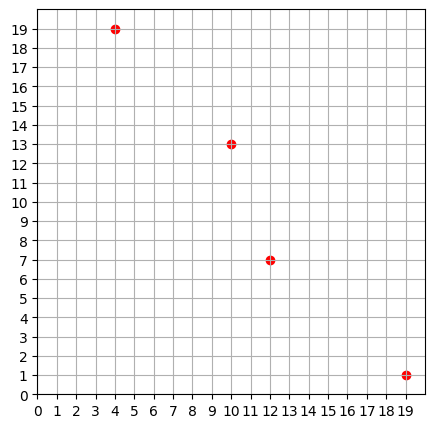

In [6]:
grover.plot_cities_on_grid()

Both solvers are run to compare their results

In [7]:
solution_brute = brute.solve_tsp(cities)
solution_grover = grover.solve_tsp(cities, verbose = True)

RESULT_bin: [('100100', 37), ('011000', 29), ('000111', 29), ('001001', 28), ('001000', 26), ('010001', 26), ('100010', 25), ('110001', 24), ('001011', 24), ('100110', 24), ('000110', 23), ('010010', 23), ('111001', 23), ('000100', 22), ('000001', 22), ('100001', 21), ('110010', 21), ('011101', 20), ('111101', 20), ('101001', 19)]
RESULT_dec: [('0321', 37, 58), ('0231', 29, 46), ('0124', 29, 'Invalid'), ('0132', 28, 46), ('0131', 26, 'Invalid'), ('0212', 26, 'Invalid'), ('0313', 25, 'Invalid'), ('0412', 24, 'Invalid'), ('0134', 24, 'Invalid'), ('0323', 24, 'Invalid'), ('0123', 23, 58), ('0213', 23, 46), ('0432', 23, 'Invalid'), ('0121', 22, 'Invalid'), ('0112', 22, 'Invalid'), ('0312', 21, 46), ('0413', 21, 'Invalid'), ('0242', 20, 'Invalid'), ('0442', 20, 'Invalid'), ('0332', 19, 'Invalid')]


In [8]:
print(
    f"The brute force solver found sequence {solution_brute} with travel"
    f"distance of {brute.get_total_travel_distance(solution_brute)}.\n"
    f"sequence validity is {brute.is_sequence_valid(solution_grover)}"
)
print(
    f"The grover solver found sequence {solution_grover} with travel"
    f"distance of {grover.get_total_travel_distance(solution_grover)}\nThe "
    f"sequence validity is {grover.is_sequence_valid(solution_grover)}"
)

The brute force solver found sequence 0132 with traveldistance of 46.

The grover solver found sequence 0321 with traveldistance of 58
The sequence validity is True


Cities and the solutions are visualized with `plot_sequence`. Below you firstly
see the brute force solution and below that the solution the grover algorithm
found.

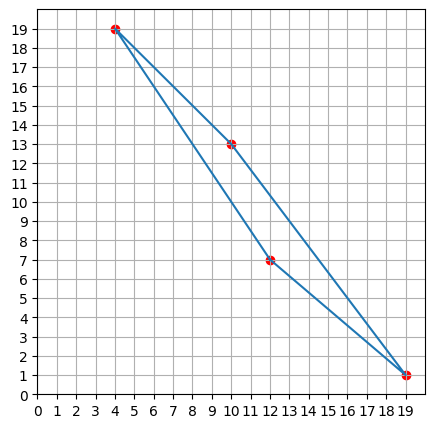

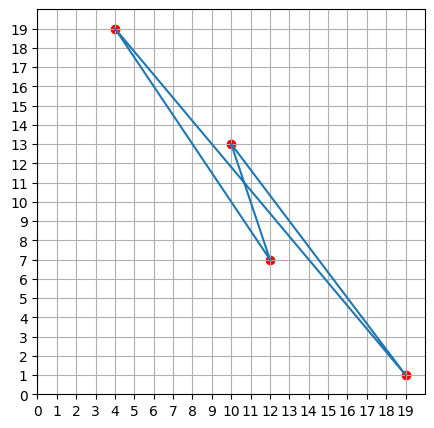

In [9]:
brute.grid_size = 20
brute.plot_sequence(solution_brute)
grover.plot_sequence(solution_grover)

The demonstration below was only a single run for a given set of cities. Now we
want to do some statistiacal analysis on how the Grover algorithm scales with
an increasing grid size of cities. We are examining map sizes ranging from
22 to 6 units per axis. Since we are limited by 5 memory qubits in the quantum
algorithm it is not possible to incorporate distances larger than $5^2$ = 32.
The maximum distance on a 22x22 grid is the diagonal with $\sqrt{2}\cdot22 < 32$

In [11]:
scaled_results = {}
for size in np.arange(22,4,-2, dtype = int):
    paths = []
    for i in range(10):
        cities = grover.set_cities_coordinates(4, size)
        brute.cities = cities
        solution_brute = brute.solve_tsp(cities)
        solution_grover = grover.solve_tsp(cities)
        same = helpers.sequences_are_equal(solution_brute, solution_grover)
        grover_dist = grover.get_total_travel_distance(solution_grover)
        brute_dist = grover.get_total_travel_distance(solution_brute)
        if grover_dist == 'Invalid':
            correct = False
        elif int(grover_dist) == int(brute_dist):
            correct = True
        else:
            correct = False


The success rates of the grover solver for a given map size can be extracted
from the `scaled_results`

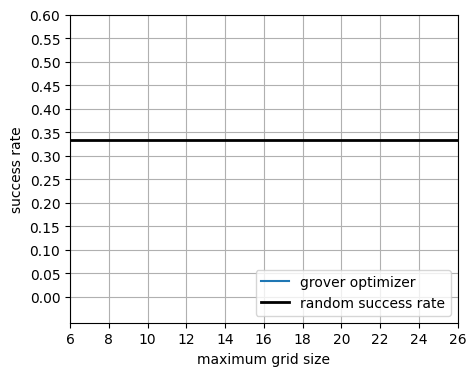

In [13]:
fig, ax = plt.subplots(figsize = (5,4))
ax.plot(
    scaled_results.keys(),
    scaled_results.values(),
    label = 'grover optimizer'
    )
ax.set_xlim(8, 26)
ax.set_xticks(np.arange(6,28,2))
ax.set_xlabel('maximum grid size')
ax.set_yticks(np.arange(0,0.6+ 0.05, 0.05))
ax.set_ylabel('success rate')
ax.axhline(1/3, color = 'k', linewidth = 2, label = 'random success rate')
ax.grid()
ax.legend(loc = 'lower right')

On first glance, the results seem rather underwhelming with success rates just 
around the guessing success rate (1/3 = 1/(number of possible solutions)).
However it is remarkable that the Grover algorithm is able to extract all the
valid results. We would likely achive higher success rates if we would repeat
this circuit for a total amont of 5 times. The circuit encodes the sequence on
a qubit register of 6 with gives rise to $2^6=64$ possible solutions.

$N_{optimal} = \left[\frac{\pi}{4}\sqrt{N}-1/2\right] =5$ with N = 64

In [ ]:
grover.qc.draw()

┌───┐                                                            »
 q56100_0: ┤ H ├──■────────────────────────■─────────■──────────────────────»
           ├───┤  │                        │         │                      »
 q56100_1: ┤ H ├──┼────■───────────────────┼────■────┼────■─────────────────»
           ├───┤┌─┴─┐  │  ┌───┐     ┌───┐┌─┴─┐  │    │    │                 »
 q56100_2: ┤ H ├┤ X ├──┼──┤ X ├──■──┤ X ├┤ X ├──┼────┼────┼─────────────────»
           ├───┤└───┘┌─┴─┐├───┤  │  ├───┤└───┘┌─┴─┐  │    │                 »
 q56100_3: ┤ H ├─────┤ X ├┤ X ├──■──┤ X ├─────┤ X ├──┼────┼─────────────────»
           ├───┤     └───┘└───┘  │  └───┘     └───┘┌─┴─┐  │  ┌───┐     ┌───┐»
 q56100_4: ┤ H ├─────────────────┼─────────────────┤ X ├──┼──┤ X ├──■──┤ X ├»
           ├───┤                 │                 └───┘┌─┴─┐├───┤  │  ├───┤»
 q56100_5: ┤ H ├─────────────────┼──────────────────────┤ X ├┤ X ├──■──┤ X ├»
           └───┘               ┌─┴─┐┌───┐               └───┘└───┘  │  └───┘»
 q56100_6: ────────────────────┤ X ├┤ X ├───────────────────────────┼───────»
                               └───┘└───┘                         ┌─┴─┐┌───┐»
 q56100_7: ───────────────────────────────────────────────────────┤ X ├┤ X ├»
                                                                  └───┘└───┘»
 q56100_8: ─────────────────────────────────────────────────────────────────»
                                                                            »
 q56100_9: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_10: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_11: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_12: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_13: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_14: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_15: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_16: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_17: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_18: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_19: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_20: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_21: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_22: ─────────────────────────────────────────────────────────────────»
                                                                            »
q56100_23: ─────────────────────────────────────────────────────────────────»
           ┌───┐                                                            »
q56100_24: ┤ X ├────────────────────────────────────────────────────────────»
           └───┘                                                            »
  c1100: 6/══════════════════════